# 5-FU STAD Samples

In [ ]:
# Set the working directory to the location of DNA_REPi 5-Fluorouracil data files
source('../../functions.R')
setwd('../../DNA_REPi/5-Fluorouracil/Expression_Mutation_CNA')

In [ ]:
#---------------------------------------------------------------------------------------------------------------

#process_tsv_files('TCGA - EMC DNA_REPi Fluorouracil Resistant STAD Samples CNA.tsv','TCGA - EMC DNA_REPi Fluorouracil Resistant STAD Samples Gene Expression.tsv')


# Gene symbol conversion table for standardized processing
conversion_table <- data.frame(
        Old.Symbol = c("SH2D3C", "CCN1", "SH3D19", "RIN2", "LCP1", "SLA", "PMEPA1", "ENC1", "DSP", "HEBP1", "CNKSR3", "TCF4", "DLC1", "HOOK1", "SCG2"),
        Converted.Symbol = c("CHAT", "PPP3CA", "EBP", "RASSF4", "LPL", "SEPSECS", "STAG1", "CCL28", "DSPP", "NFE2L2", "MAGI1", "TCF7L2", "DYNLL1", "HK1", "MEN1")
)

# Process data for sensitive and resistant samples of Fluorouracil in STAD
DNAi_Fluoroucail_STAD = process_drug_data(
        expr_sensitive_file = 'TCGA - EMC DNA_REPi Fluorouracil Sensitive STAD Samples Gene Expression.tsv',
        cna_sensitive_file = 'TCGA - EMC DNA_REPi Fluorouracil Sensitive STAD Samples CNA.tsv',
        expr_resistant_file = 'TCGA - EMC DNA_REPi Fluorouracil Resistant STAD Samples Gene Expression.tsv',
        cna_resistant_file = 'TCGA - EMC DNA_REPi Fluorouracil Resistant STAD Samples CNA.tsv',
        mut_sensitive_file = 'TCGA - EMC DNA_REPi Fluorouracil Sensitive STAD Samples Mutation.tsv',
        mut_resistant_file = 'TCGA - EMC DNA_REPi Fluorouracil Resistant STAD Samples Mutation.tsv',
        conversion_table = conversion_table
)

# Assign factor levels for sensitive and resistant conditions
DNAi_Fluoroucail_STAD$condition = factor(DNAi_Fluoroucail_STAD$condition, levels = c('resistant','sensitive'))

#---------------------------------------------------------------------------------------------------------------
# Clinical Data Processing

# Retrieve clinical data for the TCGA-STAD project
DNAi_STAD_Clinical = get_multiple_clinical_data(tcga_project = c('TCGA-STAD'))

# Check the overlap between processed data and clinical data
sum(rownames(DNAi_Fluoroucail_STAD) %in% DNAi_STAD_Clinical$submitter_id) # 18 samples match

# Filter clinical data to retain only matching samples
DNAi_STAD_Clinical_Fluoroucail = DNAi_STAD_Clinical %>% filter(submitter_id %in% rownames(DNAi_Fluoroucail_STAD))

new_row_indices <- match(rownames(DNAi_Fluoroucail_STAD), DNAi_STAD_Clinical_Fluoroucail$submitter_id)
DNAi_STAD_Clinical_Fluoroucail <- DNAi_STAD_Clinical_Fluoroucail[new_row_indices, ]

# Create a survival object using clinical data
DNAi_STAD_Fluoroucail_Surv = Surv(
        time = DNAi_STAD_Clinical_Fluoroucail$overall_survival,
        event = DNAi_STAD_Clinical_Fluoroucail$deceased
)
#saveRDS(DNAi_STAD_Fluoroucail_Surv, 'Results/DNAi_STAD_Fluoroucail_Surv.rds')

[1] 18

### Note on Computation Time
The calculation steps for the Penalized Cox Models and the subsequent Multi-Gene Cox Models are computationally intensive and can take a significant amount of time to run.

For your convenience, you can skip re-running these analyses. The code block below allows you to directly load the pre-computed results (.rds files) to proceed with the analysis and visualization steps immediately

In [ ]:
#---------------------------------------------------------------------------------------------------------------
# Penalized Cox Regression Analysis

# Run penalized Cox regression model for Fluorouracil in STAD
DNAi_EMC_STAD_Fluorouracil_Pen_CoxModel = drug_small_sample_models_cond_penalized_with_pvalue_optimized(
        data = DNAi_Fluoroucail_STAD,
        surv_obj = DNAi_STAD_Fluoroucail_Surv,
        seed = 73
)

# Load enriched terms and extract unique genes for pathway analysis
enrich_terms = read_excel('enriched_terms.xlsx')
gen_list <- extract_unique_genes(enrich_terms)

# Process the existing models with the extracted gene list
DNAi_EMC_STAD_Fluorouracil_Pen_CoxModel <- process_models(DNAi_EMC_STAD_Fluorouracil_Pen_CoxModel, gen_list)

# Save the processed Cox models
#saveRDS(DNAi_EMC_STAD_Fluorouracil_Pen_CoxModel, 'Results/DNAi_EMC_STAD_Fluorouracil_Pen_CoxModel.rds')

In [ ]:
#---------------------------------------------------------------------------------------------------------------
# Multi-Gene Cox Models

# Run multi-gene Cox models without combination terms
multiGeneCox_DNAi_STAD = drug_multigene_models_cond_penalized(
        DNAi_Fluoroucail_STAD,
        DNAi_STAD_Fluoroucail_Surv,
        pathway_file = 'enriched_terms.xlsx',
        DNAi_EMC_STAD_Fluorouracil_Pen_CoxModel,
        combination = F,
        seed = 73
)

# Save multi-gene Cox model results
#saveRDS(multiGeneCox_DNAi_STAD, 'Results/DNAi_EMC_STAD_Fluorouracil_MultiGeneCox.rds')


### Load Pre-Computed Results

To skip the lengthy model computation steps, simply run the following code block. This will load the pre-calculated models (`DNAi_EMC_STAD_Fluorouracil_Pen_CoxModel` and `multiGeneCox_DNAi_STAD`) directly from their saved `.rds` files.

In [3]:
DNAi_EMC_STAD_Fluorouracil_Pen_CoxModel = readRDS('Results/DNAi_EMC_STAD_Fluorouracil_Pen_CoxModel.rds')
multiGeneCox_DNAi_STAD = readRDS('Results/DNAi_EMC_STAD_Fluorouracil_MultiGeneCox.rds')

Processing genes for cna 
Filtered gene list for cna : LYN, MYO1F, PINK1, TNFSF13B, PREX1 


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


$CNA

$Mutation
NULL


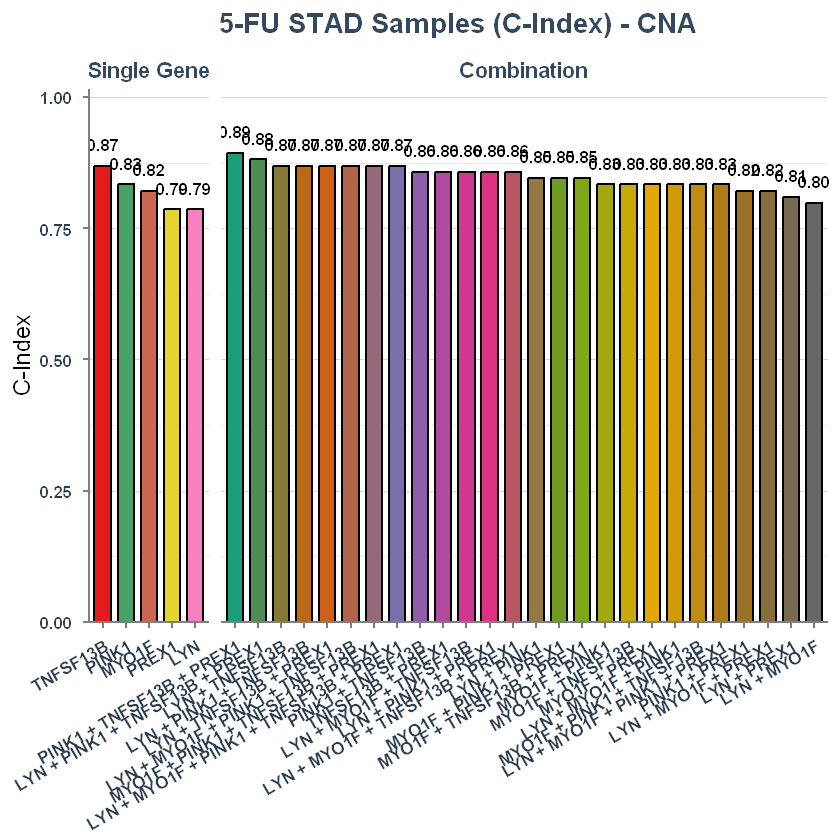

In [6]:
# Analyze and visualize specific gene combinations
results_LYN_MYO1F_PINK1_TNFSF13B_PREX1 = analyze_genes_for_combinations(
        gene_list = c('LYN', 'MYO1F', 'PINK1', 'TNFSF13B', 'PREX1', 'MAGED1'),
        processed_data = DNAi_Fluoroucail_STAD,
        surv_obj = DNAi_STAD_Fluoroucail_Surv,
        single_gene_model = DNAi_EMC_STAD_Fluorouracil_Pen_CoxModel,
        seed = 73
)

# Plot the results for gene combinations
results_LYN_MYO1F_PINK1_TNFSF13B_PREX1_plot = plot_cindex_results_separate(
        results_LYN_MYO1F_PINK1_TNFSF13B_PREX1,
        '5-FU STAD Samples (C-Index)'
)
results_LYN_MYO1F_PINK1_TNFSF13B_PREX1_plot
# Save plot for gene combinations
#saveRDS(results_LYN_MYO1F_PINK1_TNFSF13B_PREX1_plot, 'Graphs/LYN_MYO1F_PINK1_TNFSF13B_PREX1_BRCA_Cindex.rds')


New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`


Processing Model_1 
Filtered gene list for Model_1 : LYN 
Not enough genes for combinations in Model_1 . Only single genes will be used.
Processing Model_2 
No valid genes for Model_2 . Skipping...


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"
New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`


Processing Model_1 
Filtered gene list for Model_1 : TNFSF13B 
Not enough genes for combinations in Model_1 . Only single genes will be used.
Processing Model_2 
No valid genes for Model_2 . Skipping...


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


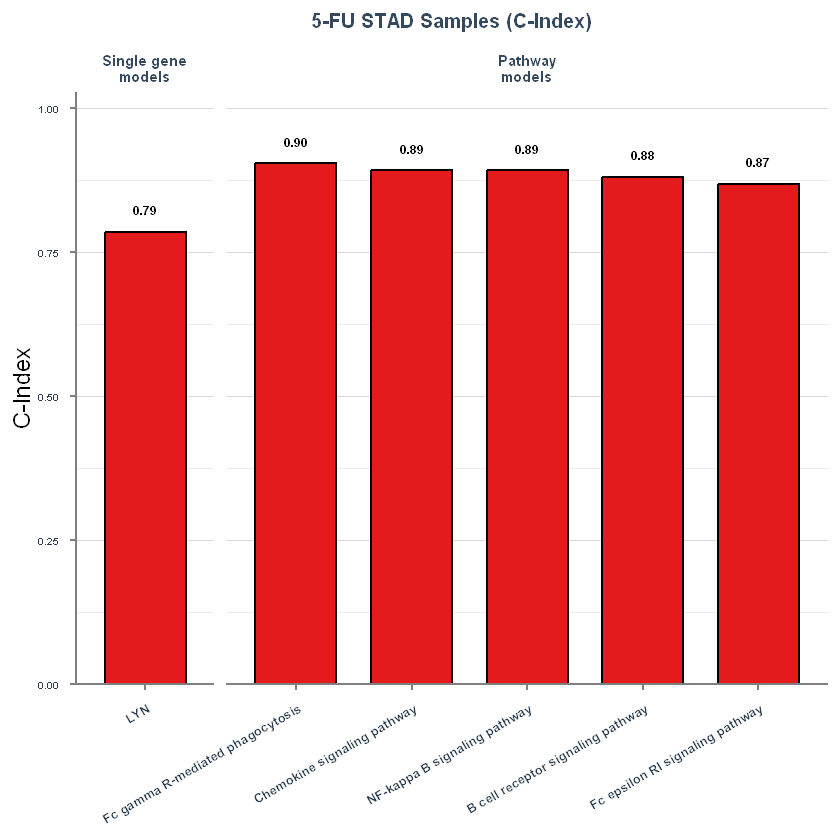

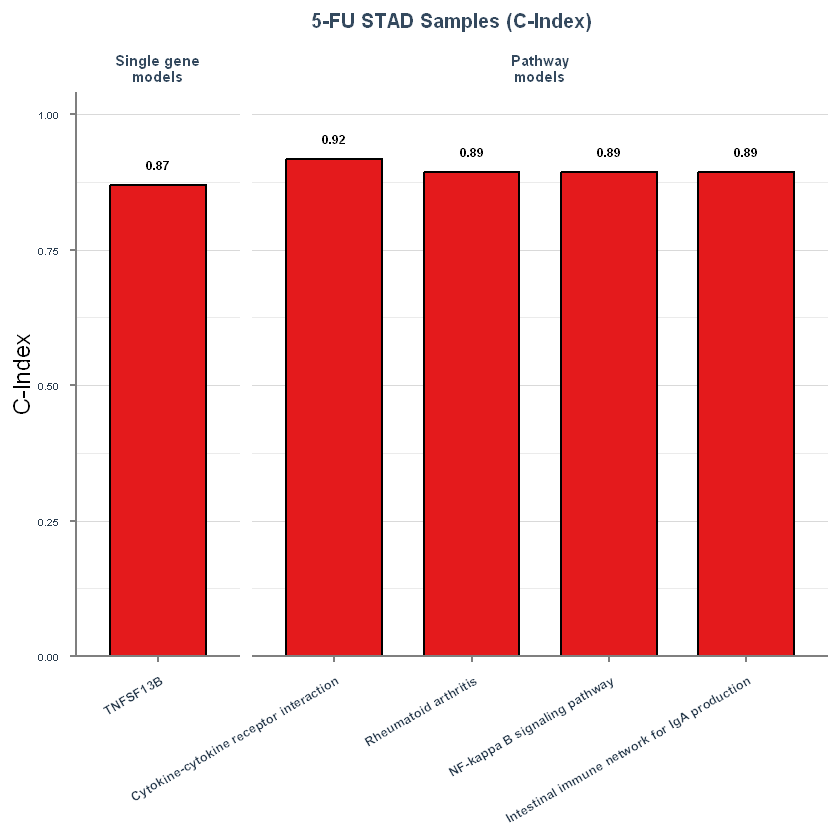

In [7]:
# Analyze specific genes and pathways
results_PINK <- analyze_genes_and_pathways_for_models(
        gene_list = c("LYN"),
        excluded_pathways = c('Viral carcinogenesis','Long-term depression','Epithelial cell signaling in Helicobacter pylori infection','Epstein-Barr virus infection','Platelet activation','Viral myocarditis','Lipid and atherosclerosis','Kaposi sarcoma-associated herpesvirus infection',"Amyotrophic lateral sclerosis", 'Pathways of neurodegeneration - multiple diseases'),
        processed_data = DNAi_Fluoroucail_STAD,
        surv_obj = DNAi_STAD_Fluoroucail_Surv,
        single_gene_model = DNAi_EMC_STAD_Fluorouracil_Pen_CoxModel,
        multi_cox_model = multiGeneCox_DNAi_STAD,
        enrichment_table_path = "enriched_terms.xlsx",
        seed = 73
)

# Generate and save barplot for specific gene results
model1_results = results_PINK$Model1
plot_model1_PINK <- cindex_barplot_vertical_v5_improved(
        model1_results,
        "Model_1",
        '5-FU STAD Samples (C-Index)'
)
plot_model1_PINK
# Save plot
#saveRDS(plot_model1_PINK, 'Graphs/LYN_BRCA_Cindex.rds')

#----------

# Analyze specific genes and pathways
results_TNFSF13B<- analyze_genes_and_pathways_for_models(
  gene_list = c("TNFSF13B"),
  excluded_pathways = c('Viral carcinogenesis','Long-term depression','Epithelial cell signaling in Helicobacter pylori infection','Epstein-Barr virus infection','Platelet activation','Viral myocarditis','Lipid and atherosclerosis','Kaposi sarcoma-associated herpesvirus infection',"Amyotrophic lateral sclerosis", 'Pathways of neurodegeneration - multiple diseases'),
  processed_data = DNAi_Fluoroucail_STAD,
  surv_obj = DNAi_STAD_Fluoroucail_Surv,
  single_gene_model = DNAi_EMC_STAD_Fluorouracil_Pen_CoxModel,
  multi_cox_model = multiGeneCox_DNAi_STAD,
  enrichment_table_path = "enriched_terms.xlsx",
  seed = 73
)

# Generate and save barplot for specific gene results
model1_results = results_TNFSF13B$Model1
plot_model1_TNFSF13B <- cindex_barplot_vertical_v5_improved(
  model1_results,
  "Model_1",
  '5-FU STAD Samples (C-Index)'
)
plot_model1_TNFSF13B
# Save plot
#saveRDS(plot_model1_TNFSF13B, 'Graphs/TNFSF13B_BRCA_Cindex.rds')


In [ ]:
#---------------------------------------------------------------------------------------------------------------
# Kaplan-Meier Survival Analysis

# Perform Kaplan-Meier analysis for filtered models
results_STAD <- kaplan_meier_analysis(
  model1_data = DNAi_EMC_STAD_Fluorouracil_Pen_CoxModel$Model_1,
  model2_data = DNAi_EMC_STAD_Fluorouracil_Pen_CoxModel$Model_2,
  surv_obj = DNAi_STAD_Fluoroucail_Surv,
  processed_data = DNAi_Fluoroucail_STAD,
  hr_threshold = 1.1,
  plot = F,
  seed = 73,
  th_pval = 0.05,
  plot_title_prefix = '5-FU STAD Samples'
)

# Save Kaplan-Meier analysis results
#saveRDS(results, 'DNAi_EMC_STAD_Fluorouracil_KM.rds')


# Generate and save KM plots for CDH1


CCND1_KM_STAD = results_STAD$Model1$Plots$CCND1_Interaction_cna_condition_HR
FOSL1_KM_STAD=results_STAD$Model1$Plots$FOSL1_Interaction_cna_condition_HR
CTTN_KM_STAD=results_STAD$Model1$Plots$CTTN_Interaction_cna_condition_HR
SLC43A1_KM_STAD=results_STAD$Model1$Plots$SLC43A1_Interaction_cna_condition_HR
SLC43A3_KM_STAD=results_STAD$Model1$Plots$SLC43A3_Interaction_cna_condition_HR

FRMD6_KM_STAD=results_STAD$Model2$Plots$FRMD6_Interaction_mut_condition_HR
TNC_KM_STAD=results_STAD$Model2$Plots$TNC_Interaction_mut_condition_HR

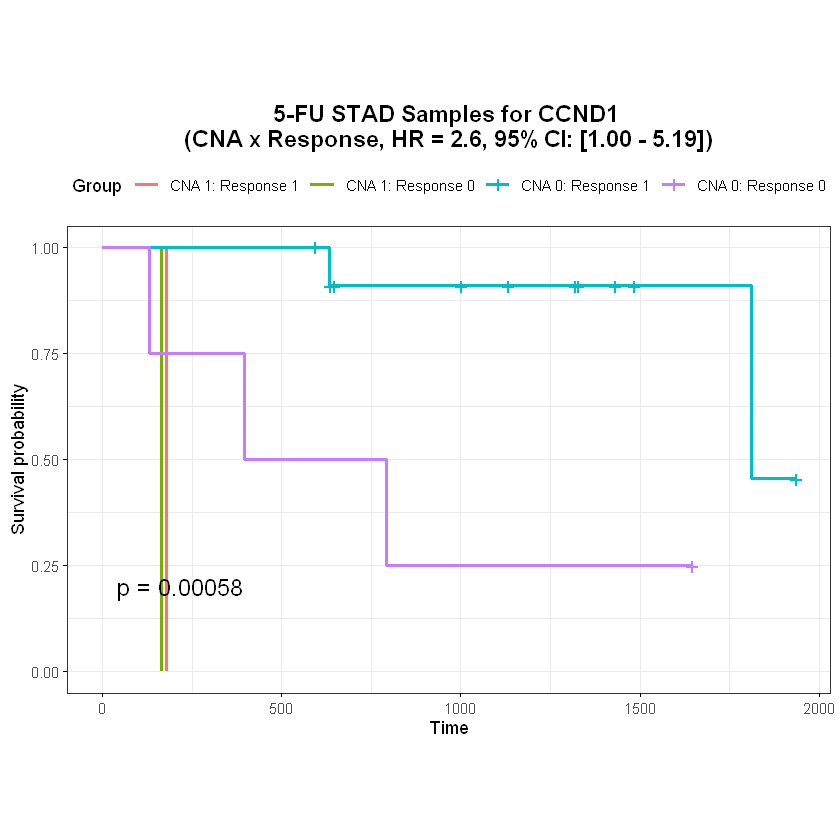

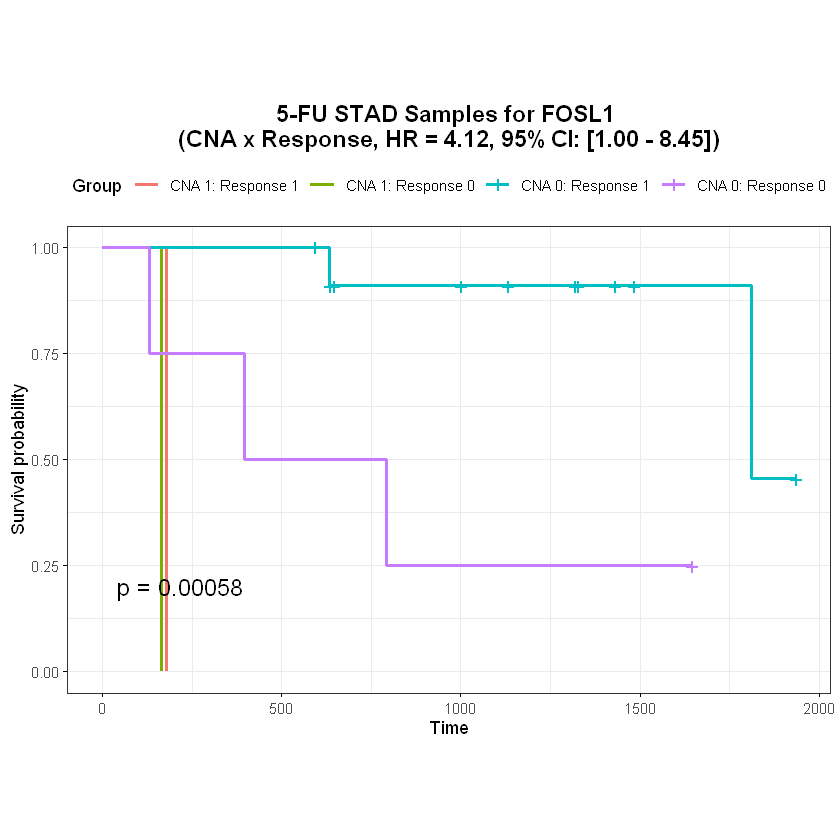

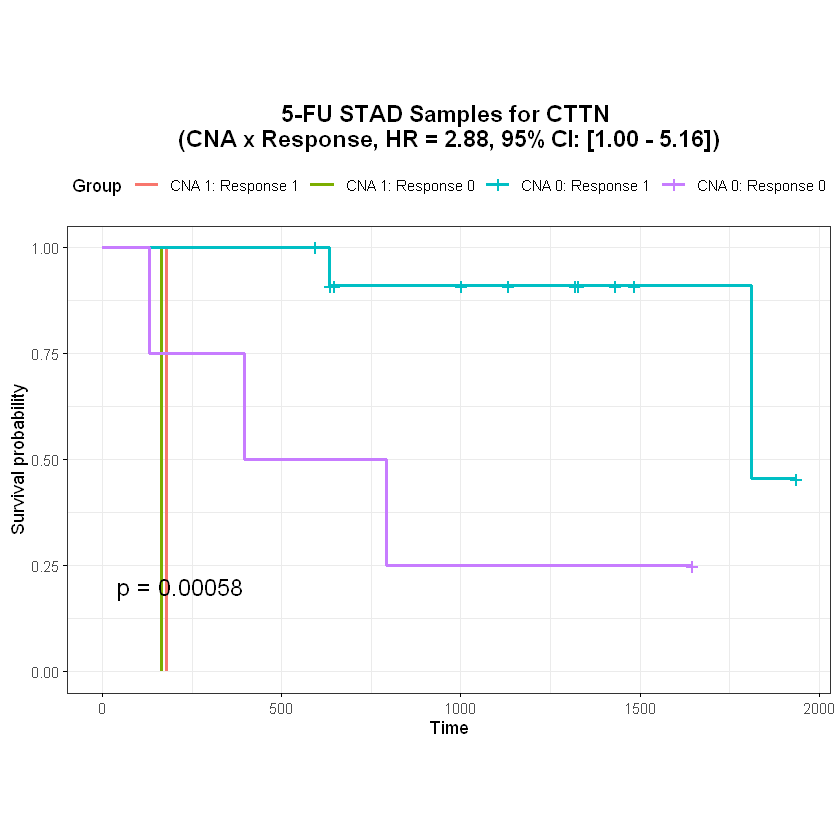

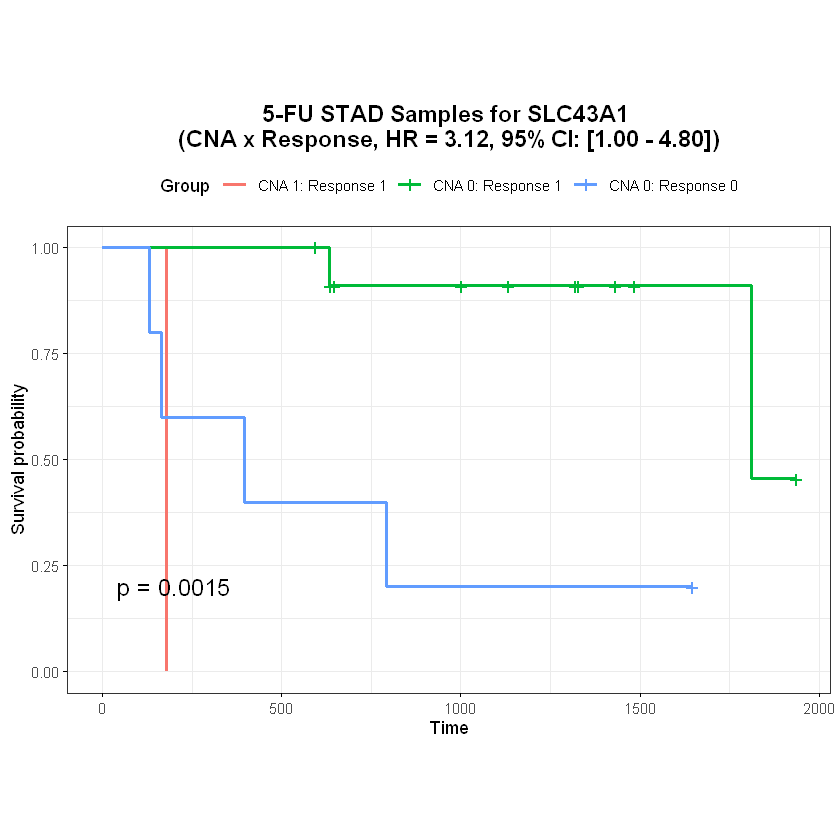

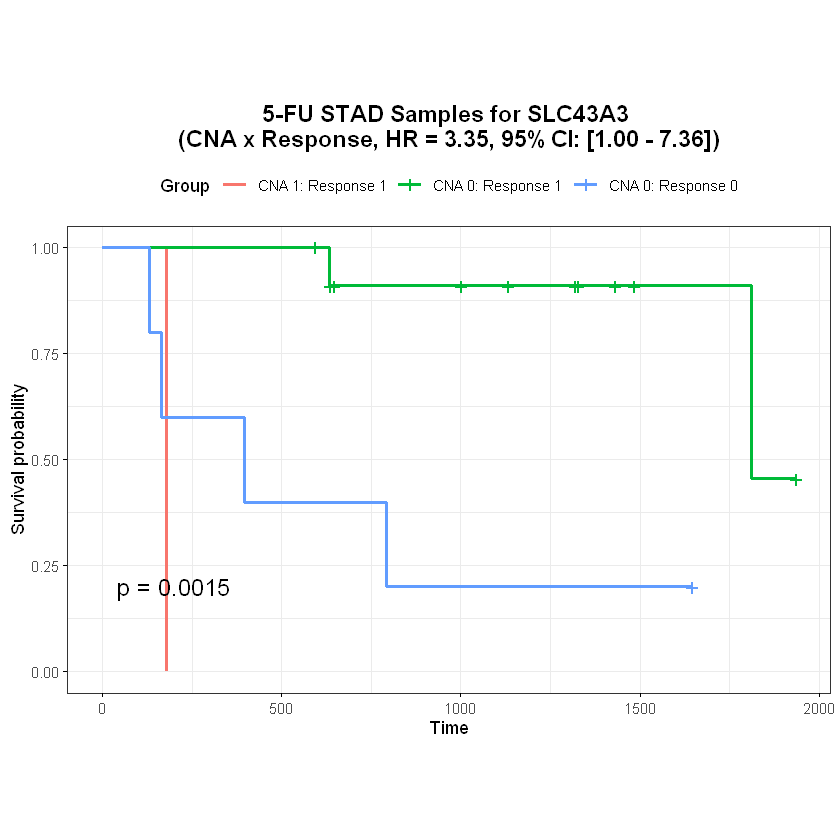

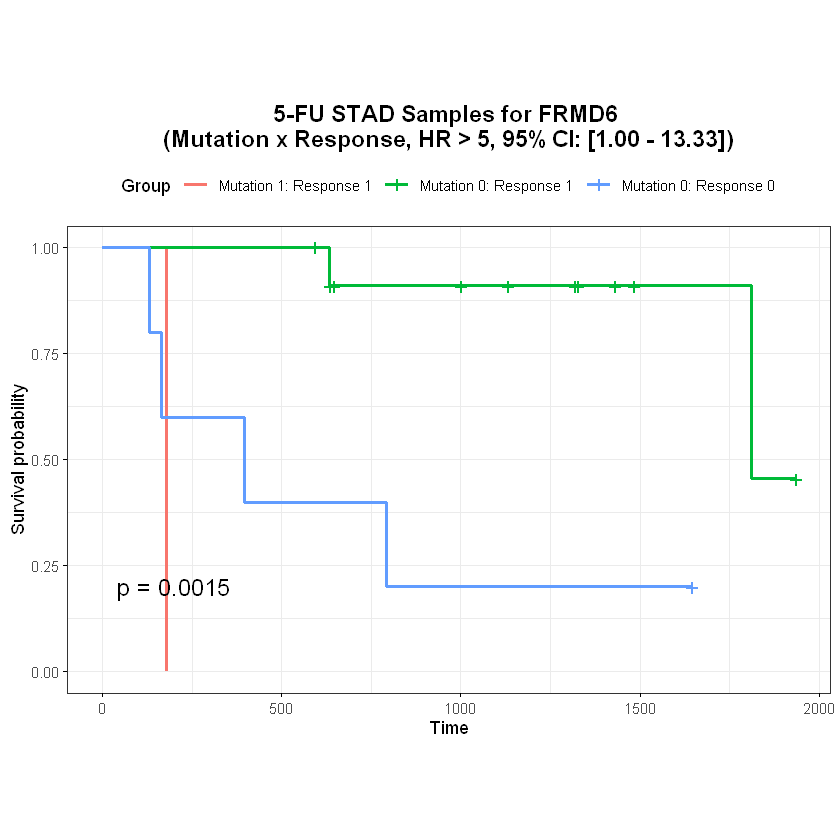

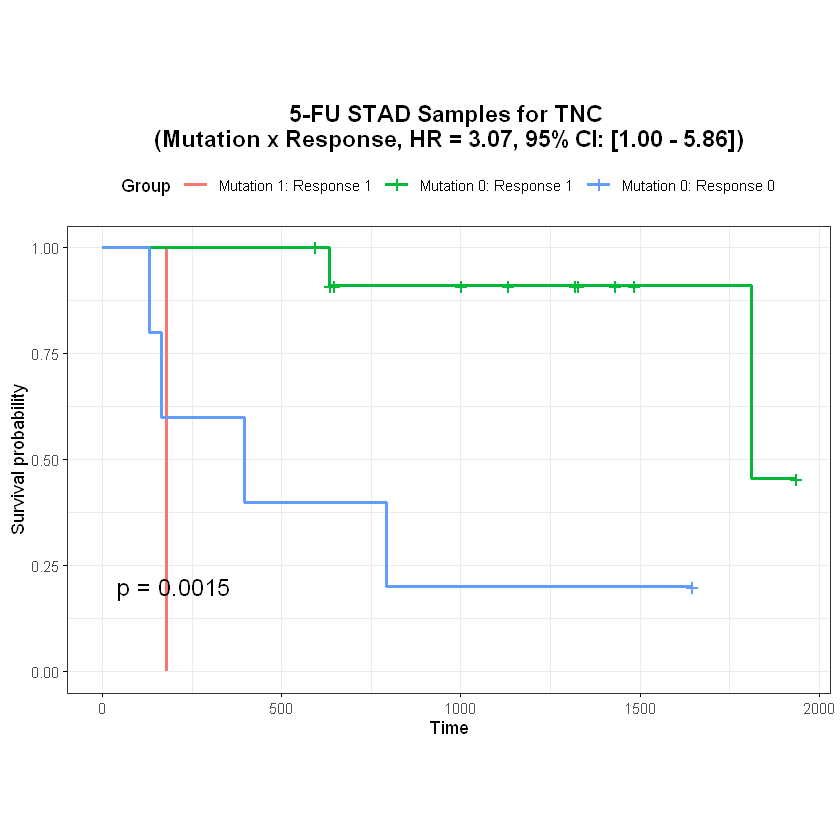

In [10]:
CCND1_KM_STAD
FOSL1_KM_STAD
CTTN_KM_STAD
SLC43A1_KM_STAD
SLC43A3_KM_STAD

FRMD6_KM_STAD
TNC_KM_STAD